In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split

In [3]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
dataset_path = "C:/Users/Admin/Desktop/cse803_hw5"

FASHION_transform = transforms.Compose([
    transforms.ToTensor(), # Transform from [0,255] uint8 to [0,1] float
    transforms.Normalize([0.2859], [0.3530]) # Normalize to zero mean and unit variance
])
FASHION_trainval = datasets.FashionMNIST(
    dataset_path,
    download=True,
    train=True,
    transform=FASHION_transform
)
FASHION_train = Subset(FASHION_trainval, range(50000))
FASHION_val = Subset(FASHION_trainval, range(50000,60000))
FASHION_test = datasets.FashionMNIST(
    dataset_path,
    download=True,
    train=False,
    transform=FASHION_transform
)
print("Done!")

# Create dataloaders
# TODO: Experiment with different batch sizes
trainloader = DataLoader(FASHION_train, batch_size=64, shuffle=True)
valloader = DataLoader(FASHION_val, batch_size=64, shuffle=True)
testloader = DataLoader(FASHION_test, batch_size=64, shuffle=True)

Loading datasets...


100%|████████████████████████████████████████| 26421880/26421880 [15:58<00:00, 27564.32it/s]


Extracting C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw\train-images-idx3-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw



100%|██████████████████████████████████████████████| 29515/29515 [00:00<00:00, 73563.12it/s]


Extracting C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw



100%|█████████████████████████████████████████| 4422102/4422102 [00:36<00:00, 122735.87it/s]


Extracting C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████| 5148/5148 [00:00<?, ?it/s]

Extracting C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\FashionMNIST\raw

Done!


In [28]:
"""
Network class.
"""
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Design your own network, define layers here.
        p_keep = 1.0
        k_size = 3
        
        # convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=k_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=1.0 - p_keep),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=k_size, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=1.0 - p_keep),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(p=1.0 - p_keep),
        )
        
        # linear layers
        self.fc1 = nn.Linear(4 * 4 * 128, 625, bias=True)
        self.fc2 = nn.Linear(625, 10, bias=True)

    def forward(self,x):
        # TODO: Design your own network, implement forward pass here
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        relu = nn.ReLU()
        x = self.fc1(x)
        x = self.fc2(relu(x))
        return x

In [29]:
"""
Hyperparameters.
"""
# configure device
device = "cuda" if torch.cuda.is_available() else "cpu"

# init model
model = Network().to(device)

# specify the loss layer
criterion = nn.CrossEntropyLoss()

# TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# TODO: choose an appropriate number of training epochs
num_epoch = 15

In [30]:
"""
Train & evaluation functions.
"""
def train(model, train_loader, val_loader, num_epoch = 10): # Train the model
    print("Start training...")
    train_losses = []
    val_losses = []
    
    for i in range(num_epoch):
        # Set the model to training mode
        model.train()
        running_loss = []
        for batch, label in tqdm(train_loader):
            # format data
            batch = batch.to(device)
            label = label.to(device)
            
            # Clear gradients from the previous iteration
            optimizer.zero_grad()
            
            # This will call Network.forward() that you implement
            pred = model(batch)
            
            # Calculate the training loss
            loss = criterion(pred, label)
            running_loss.append(loss.item())
            
            # Backprop gradients to all tensors in the network
            loss.backward()
            
            # Update trainable weights
            optimizer.step()
        
        # training loss
        train_loss = np.mean(running_loss)
        train_losses.append(train_loss)
        
        # validation loss
        _, val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        
        # report epoch results
        print(f"Epoch {i+1}: train_loss={train_loss}, val_loss={val_loss}") # Print the average losses for this epoch
    
    # finished
    print("Done!")
    return train_losses, val_losses

def evaluate(model, val_loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    running_loss = []
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(val_loader):
            # format data
            batch = batch.to(device)
            label = label.to(device)
            
            # make predictions
            pred = model(batch)
            
            # Calculate the validation loss
            loss = criterion(pred, label)
            running_loss.append(loss.item())
            
            # calculate batch accuracy
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    
    # averaged accuracy
    acc = correct / len(val_loader.dataset)
    
    # validation loss
    val_loss = np.mean(running_loss)
    
    # finished
    print("Evaluation accuracy: {}".format(acc))
    return acc, val_loss

In [31]:
"""
Train and evaluate model.
"""
# train
train_losses, val_losses = train(model, trainloader, valloader, num_epoch)

print("Evaluate on test set")
test_acc, test_loss = evaluate(model, testloader)

Start training...


100%|█████████████████████████████████████████████████████| 157/157 [00:06<00:00, 25.79it/s]


Evaluation accuracy: 0.8854
Epoch 1: train_loss=0.4385190149554816, val_loss=0.3092915424305922


100%|█████████████████████████████████████████████████████| 157/157 [00:06<00:00, 24.19it/s]


Evaluation accuracy: 0.9058
Epoch 2: train_loss=0.274183854136778, val_loss=0.2527780517176458


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.34it/s]


Evaluation accuracy: 0.9142
Epoch 3: train_loss=0.22963903001640612, val_loss=0.23309230263445788


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 19.00it/s]


Evaluation accuracy: 0.9154
Epoch 4: train_loss=0.19866147610689977, val_loss=0.23721835638876934


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.08it/s]


Evaluation accuracy: 0.9109
Epoch 5: train_loss=0.17507365926185534, val_loss=0.2526320010233837


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.87it/s]


Evaluation accuracy: 0.9175
Epoch 6: train_loss=0.15523434947232914, val_loss=0.234597207847864


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.99it/s]


Evaluation accuracy: 0.9116
Epoch 7: train_loss=0.13570667204478054, val_loss=0.24483280605191637


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.79it/s]


Evaluation accuracy: 0.9232
Epoch 8: train_loss=0.12238832301748416, val_loss=0.23161067946511468


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.84it/s]


Evaluation accuracy: 0.9189
Epoch 9: train_loss=0.1071148154211452, val_loss=0.251694498215891


100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 19.05it/s]


Evaluation accuracy: 0.9154
Epoch 10: train_loss=0.0939529342279124, val_loss=0.26209185725659323


100%|█████████████████████████████████████████████████████| 157/157 [00:09<00:00, 16.80it/s]


Evaluation accuracy: 0.9195
Epoch 11: train_loss=0.08425614969445216, val_loss=0.2584816863297657


100%|█████████████████████████████████████████████████████| 157/157 [00:10<00:00, 15.53it/s]


Evaluation accuracy: 0.9195
Epoch 12: train_loss=0.07608472997063051, val_loss=0.26564337550454836


100%|█████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.13it/s]


Evaluation accuracy: 0.9241
Epoch 13: train_loss=0.06682055746621983, val_loss=0.2705246946851539


100%|█████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.39it/s]


Evaluation accuracy: 0.9187
Epoch 14: train_loss=0.0624846603490336, val_loss=0.30572927756246865


100%|█████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.68it/s]


Evaluation accuracy: 0.9245
Epoch 15: train_loss=0.05878073636762788, val_loss=0.28560154841156904
Done!
Evaluate on test set


100%|█████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.53it/s]

Evaluation accuracy: 0.9189


       training_loss  validation_loss
epoch                                
0           0.438519         0.309292
1           0.274184         0.252778
2           0.229639         0.233092
3           0.198661         0.237218
4           0.175074         0.252632
5           0.155234         0.234597
6           0.135707         0.244833
7           0.122388         0.231611
8           0.107115         0.251694
9           0.093953         0.262092
10          0.084256         0.258482
11          0.076085         0.265643
12          0.066821         0.270525
13          0.062485         0.305729
14          0.058781         0.285602


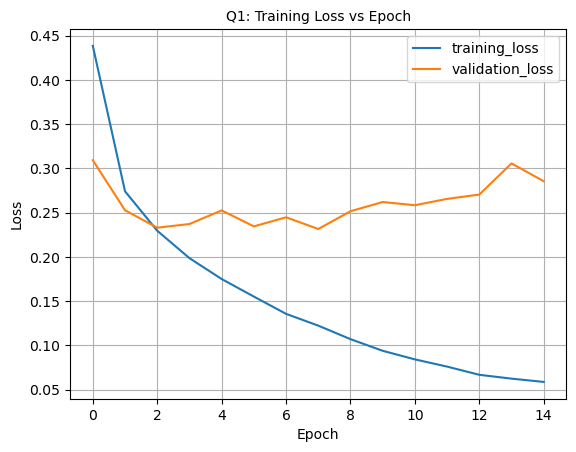

In [38]:
"""
Analyze training & evaluation results.
"""
results = []
for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
    results.append({
        'epoch': i,
        'training_loss': t_loss,
        'validation_loss': v_loss,
    })

results_df = pd.DataFrame.from_records(results).set_index('epoch')
print(results_df)

# plot figure
results_df.plot(
    xlabel="Epoch",
    ylabel="Loss",
    grid=True,
)
plt.title("Q1: Training Loss vs Epoch", fontsize=10)
plt.savefig(f"./figures/{"q1_losses"}.png")